# P-property check function

In [1]:
# checking if a matrix is p-matrix
import numpy as np
from itertools import combinations
import pandas as pd

def generate_subsets(n):
    # Generate all possible subsets of size 1 to n.
    for size in range(1, n + 1):
        for subset in combinations(range(n), size):
            yield subset
            # print(subset)

def check_p(matrix):
    n = len(matrix)

    # Compute the determinant of the whole matrix first.
    determinant = np.linalg.det(matrix)
    if determinant <= 0:
        return "Not a p-matrix"  # Return immediately if the whole matrix has a non-positive determinant

    # Check the determinants of diagonal elements (smallest subset) next.
    for i in range(n):
        submatrix = matrix[i, i]
        if submatrix <= 0:
            return "Not a p-matrix"  # Return immediately if any diagonal element is non-positive

    # Initialize the generator to get subsets.
    subset_generator = generate_subsets(n)

    # Check the determinants of other subsets.
    for subset in subset_generator:
        if len(subset) > 1:
            submatrix = matrix[np.ix_(subset, subset)]
            determinant = np.linalg.det(submatrix)
            if determinant <= 0:
                return "Not a p-matrix"  # Return immediately if a non-positive determinant is found

    return "All principal minors are positive -> p-matrix"


In [2]:
# Example usage:
matrix = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
matrix_i = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
result = check_p(matrix)
print('\n')
result_i = check_p(matrix_i)
print(result)
print(result_i)



Not a p-matrix
All principal minors are positive -> p-matrix


- note: for a 25 by 25 matrix it takes about 6 minutes --> no way to do this for 100 by 100 matrix!!

# Calls network

In [3]:
import pandas as pd
import networkx as nx

# Load the dataset
df_calls = pd.read_csv('/Users/macbook/Desktop/Research/MultilayerGame/Copenhagen study/calls.csv')

# Display the first few rows of the dataset
print(df_calls.head())
# plot histogram of call durations
# plt.hist(df_calls['duration'], bins=20)

   timestamp  caller  callee  duration
0        184     300     301       121
1       3920     512     299       670
2       5623     301     300       504
3       9252     401     457        -1
4      15466     512       0         5


In [4]:
# Drop the 'timestamp' column
df_calls = df_calls.drop(columns=['timestamp'])

# Normalize the 'duration' column
df_calls['duration'] = df_calls['duration'] / df_calls['duration'].max()

# Display the modified dataset
print(df_calls.head())

   caller  callee  duration
0     300     301  0.023550
1     512     299  0.130401
2     301     300  0.098093
3     401     457 -0.000195
4     512       0  0.000973


In [5]:
# Create a directed graph
G_calls = nx.DiGraph()

# Add nodes (callers and callees) to the graph
nodes = set(df_calls['caller']).union(set(df_calls['callee']))
G_calls.add_nodes_from(nodes)

# Add edges with normalized duration as edge weights
for index, row in df_calls.iterrows():
    G_calls.add_edge(row['caller'], row['callee'], weight=row['duration'])

# Display basic graph information
print(nx.info(G_calls))

DiGraph with 536 nodes and 924 edges


/var/folders/hs/y116vr4j4yg5fcthw_l99c5r0000gn/T/ipykernel_8716/4160514428.py:13: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(G_calls))


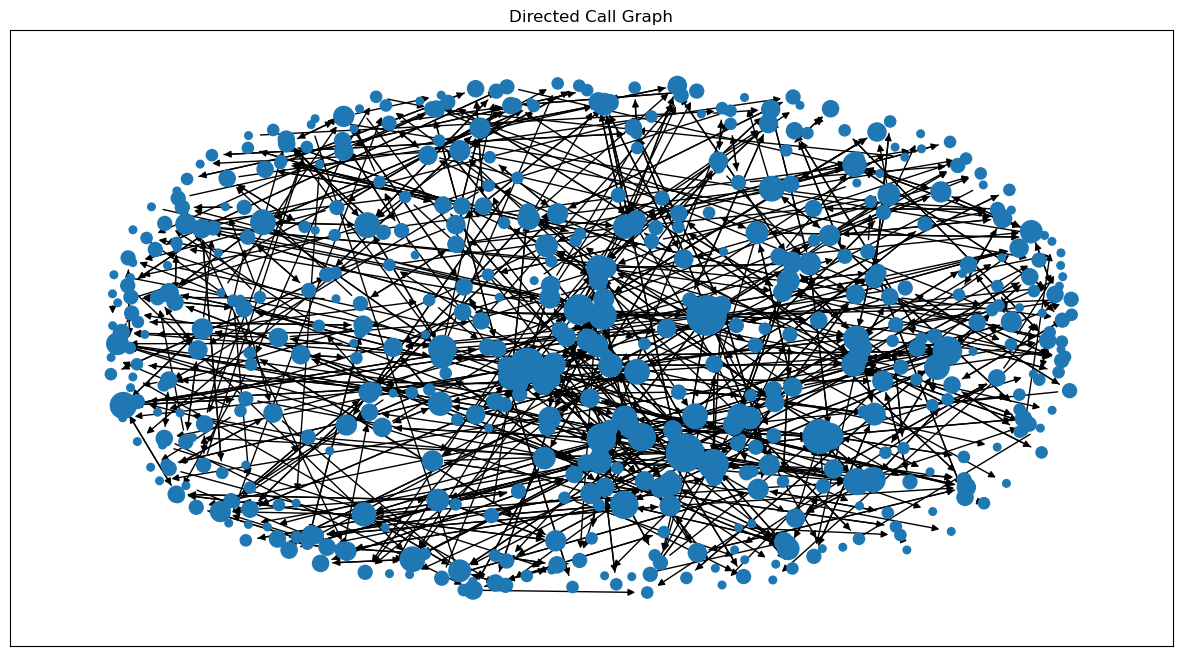

In [6]:
import matplotlib.pyplot as plt

# Plot the graph
plt.figure(figsize=(15, 8))
# Calculate node connectivity based on in-degree and out-degree
node_connectivity = {node: G_calls.in_degree(node) + G_calls.out_degree(node) for node in G_calls.nodes()}

# Scale the node sizes for visualization
min_size = 30  # Minimum node size
max_size = 800  # Maximum node size
scaled_connectivity = {node: (node_connectivity[node] - min(node_connectivity.values())) /
                       (max(node_connectivity.values()) - min(node_connectivity.values())) *
                       (max_size - min_size) + min_size for node in G_calls.nodes()}

pos = nx.spring_layout(G_calls, seed=42)  # Positioning the nodes
nodes = nx.draw_networkx_nodes(G_calls, pos, node_size=list(scaled_connectivity.values()))
edges = nx.draw_networkx_edges(G_calls, pos)


# Add edge labels with durations
# edge_labels = {(u, v): f"{d:.2f}" if d != -1 else '-1' for u, v, d in G_calls.edges(data='weight')}
# nx.draw_networkx_edge_labels(G_calls, pos, edge_labels=edge_labels, font_size=8, verticalalignment='baseline')
# save figure
# plt.savefig('call_graph.png')
plt.title('Directed Call Graph')
plt.show()

# SMS network

In [7]:
# Load the dataset
df_sms = pd.read_csv('/Users/macbook/Desktop/Research/MultilayerGame/Copenhagen study/sms.csv')

# Drop the 'timestamp' column
df_sms = df_sms.drop(columns=['timestamp'])

# Create a new column 'count' to store the number of times A texted B
df_sms['count'] = 1

# Group by sender and recipient, and sum the 'count' column to get unique combinations
df_sms_grouped = df_sms.groupby(['sender', 'recipient'], as_index=False).sum()

# Normalize the 'count' column
max_count = df_sms_grouped['count'].max()
df_sms_grouped['normalized_count'] = df_sms_grouped['count'] / max_count if max_count != 0 else 1

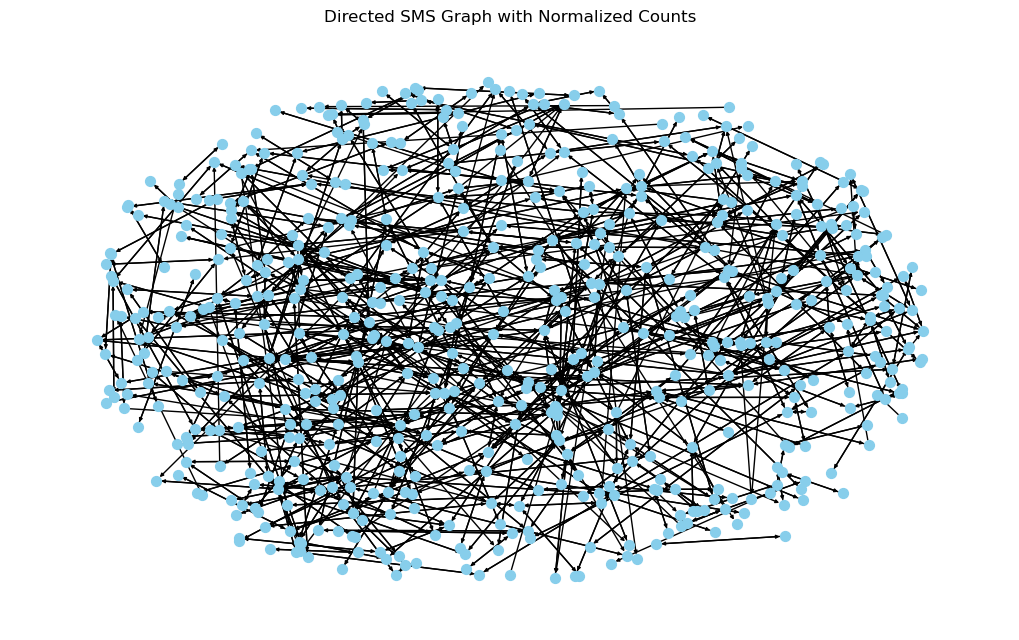

DiGraph with 568 nodes and 1303 edges


/var/folders/hs/y116vr4j4yg5fcthw_l99c5r0000gn/T/ipykernel_8716/3523227711.py:31: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(G_sms))


In [8]:

# Create a directed graph
G_sms = nx.DiGraph()

# Add nodes (senders and recipients) to the graph
nodes = set(df_sms_grouped['sender']).union(set(df_sms_grouped['recipient']))
G_sms.add_nodes_from(nodes)

# Add edges with normalized 'count' column as edge weights
for index, row in df_sms_grouped.iterrows():
    sender = row['sender']
    recipient = row['recipient']
    normalized_count = row['normalized_count']
    
    G_sms.add_edge(sender, recipient, weight=normalized_count)

# Plot the graph
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G_sms, seed=42)  # Positioning the nodes
nx.draw(G_sms, pos, node_size=50, font_size=10, node_color='skyblue', font_color='black', arrowsize=5)

# Add edge labels with normalized counts
# edge_labels = {(u, v): f"{w:.2f}" for u, v, w in G_sms.edges(data='weight')}
# nx.draw_networkx_edge_labels(G_sms, pos, edge_labels=edge_labels, font_size=8, verticalalignment='baseline')

# save figure
# plt.savefig('sms_graph.png')
plt.title('Directed SMS Graph with Normalized Counts')
plt.show()

# print the number of nodes and edges
print(nx.info(G_sms))

# Filtering the nodes that exist in all layers - Calls, SMS, Facebook

## Processing calls dataset

In [9]:
import pandas as pd

# Load the 'calls.csv' dataset
calls_df = pd.read_csv('/Users/macbook/Desktop/Research/MultilayerGame/Copenhagen study/calls.csv')

# Drop the 'timestamp' column
calls_df = calls_df.drop(columns=['timestamp'])

# Normalize the 'duration' column
max_duration = calls_df['duration'].max()
calls_df['duration'] = calls_df['duration'] / max_duration if max_duration != 0 else 1

# Display the processed dataset
print(calls_df.head())

   caller  callee  duration
0     300     301  0.023550
1     512     299  0.130401
2     301     300  0.098093
3     401     457 -0.000195
4     512       0  0.000973


## Processing sms dataset

In [10]:
# Load the 'sms.csv' dataset
sms_df = pd.read_csv('/Users/macbook/Desktop/Research/MultilayerGame/Copenhagen study/sms.csv')

# Drop the 'timestamp' column
sms_df = sms_df.drop(columns=['timestamp'])

# Create a new column 'count' to store the number of times A texted B
sms_df['count'] = 1

# Group by sender and recipient, and sum the 'count' column to get unique combinations
sms_df_grouped = sms_df.groupby(['sender', 'recipient'], as_index=False).sum()

# Normalize the 'count' column
max_count = sms_df_grouped['count'].max()
sms_df_grouped['normalized_count'] = sms_df_grouped['count'] / max_count if max_count != 0 else 1

# Display the processed dataset
print(sms_df_grouped.head())

   sender  recipient  count  normalized_count
0       0        208      1          0.000691
1       0        512     61          0.042127
2       1        345      2          0.001381
3       3         49     41          0.028315
4       3        217      3          0.002072


## Processing facebook dataset

   # user_a  user_b
0         0     512
1         0     263
2         0     525
3         0     285
4         0     543


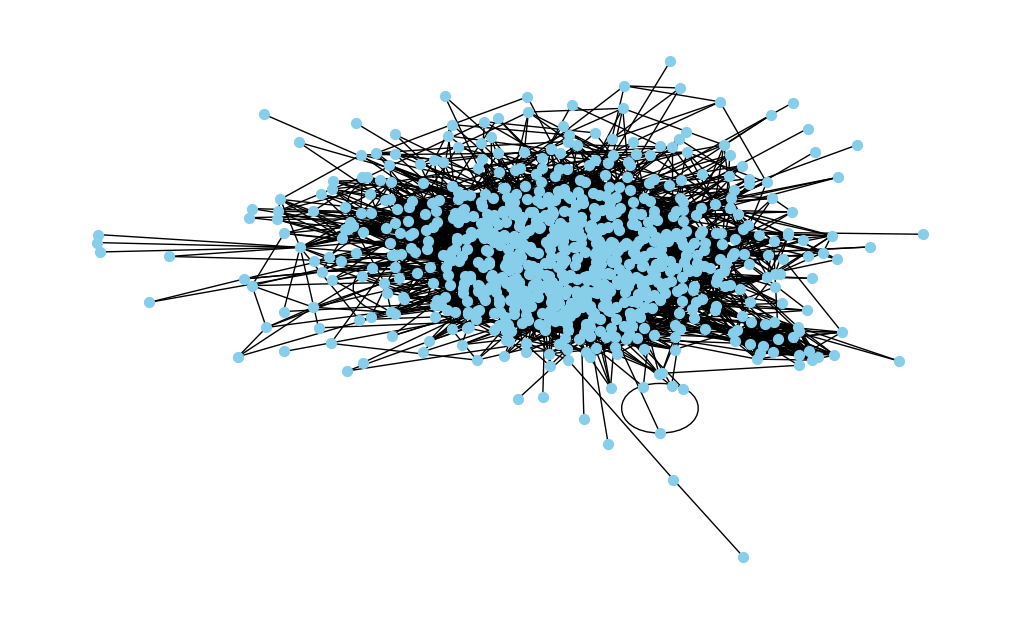

In [11]:
# Load the 'fb_friends.csv' dataset
fb_friends_df = pd.read_csv('/Users/macbook/Desktop/Research/MultilayerGame/Copenhagen study/fb_friends.csv')

# Display the processed dataset
print(fb_friends_df.head())


G_fb_friends = nx.Graph()

nodes = set(fb_friends_df['# user_a']).union(set(fb_friends_df['user_b']))
G_fb_friends.add_nodes_from(nodes)
G_fb_friends.add_edges_from(fb_friends_df[['# user_a', 'user_b']].values)


# Plot the graph
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G_fb_friends, seed=42)  # Positioning the nodes
nx.draw(G_fb_friends, pos, node_size=50, font_size=10, node_color='skyblue', font_color='black', arrowsize=5)

# Add edge labels with normalized counts
# edge_labels = {(u, v): f"{w:.2f}" for u, v, w in G_sms.edges(data='weight')}
# nx.draw_networkx_edge_labels(G_sms, pos, edge_labels=edge_labels, font_size=8, verticalalignment='baseline')

# save figure
# plt.savefig('fb_graph.png')
# plt.title('Directed SMS Graph with Normalized Counts')
plt.show()

## Filtering the nodes

In [12]:
# Identify common entities (nodes) across datasets
common_nodes = set(calls_df['caller']).intersection(set(calls_df['callee']))
common_nodes = common_nodes.intersection(set(sms_df_grouped['sender']))
common_nodes = common_nodes.intersection(set(sms_df_grouped['recipient']))
common_nodes = common_nodes.intersection(set(fb_friends_df['# user_a']))
common_nodes = common_nodes.intersection(set(fb_friends_df['user_b']))

# Filter dataframes to keep only common nodes
calls_df_common = calls_df[(calls_df['caller'].isin(common_nodes)) & (calls_df['callee'].isin(common_nodes))]
sms_df_common = sms_df_grouped[(sms_df_grouped['sender'].isin(common_nodes)) & (sms_df_grouped['recipient'].isin(common_nodes))]
fb_friends_df_common = fb_friends_df[(fb_friends_df['# user_a'].isin(common_nodes)) & (fb_friends_df['user_b'].isin(common_nodes))]

# Display the resulting common dataframes
print("Calls DataFrame (Common Nodes):\n", calls_df_common.head())
print("SMS DataFrame (Common Nodes):\n", sms_df_common.head())
print("Facebook Friends DataFrame (Common Nodes):\n", fb_friends_df_common.head())


Calls DataFrame (Common Nodes):
    caller  callee  duration
0     300     301  0.023550
1     512     299  0.130401
2     301     300  0.098093
3     401     457 -0.000195
6      19      47  0.120475
SMS DataFrame (Common Nodes):
     sender  recipient  count  normalized_count
29      13        492     27          0.018646
31      13        583     14          0.009669
35      15         58      1          0.000691
36      15        100     10          0.006906
37      15        221      1          0.000691
Facebook Friends DataFrame (Common Nodes):
     # user_a  user_b
19       256     524
24       256     421
25       256     706
30       512     560
32       512     580


In [13]:
# Create a directed graph for each dataset with common nodes
G_calls = nx.DiGraph()
G_calls.add_nodes_from(common_nodes)
G_calls.add_weighted_edges_from(calls_df_common[['caller', 'callee', 'duration']].values)

G_sms = nx.DiGraph()
G_sms.add_nodes_from(common_nodes)
G_sms.add_weighted_edges_from(sms_df_common[['sender', 'recipient', 'normalized_count']].values)

G_fb_friends = nx.Graph()
G_fb_friends.add_nodes_from(common_nodes)
G_fb_friends.add_edges_from(fb_friends_df_common[['# user_a', 'user_b']].values)

# Print the number of nodes and edges for each graph
print("Number of nodes and edges in Calls Graph:")
print("Nodes:", len(G_calls.nodes))
print("Edges:", len(G_calls.edges))
print()

print("Number of nodes and edges in SMS Graph:")
print("Nodes:", len(G_sms.nodes))
print("Edges:", len(G_sms.edges))
print()

print("Number of nodes and edges in Facebook Friends Graph:")
print("Nodes:", len(G_fb_friends.nodes))
print("Edges:", len(G_fb_friends.edges))

Number of nodes and edges in Calls Graph:
Nodes: 296
Edges: 517

Number of nodes and edges in SMS Graph:
Nodes: 296
Edges: 606

Number of nodes and edges in Facebook Friends Graph:
Nodes: 296
Edges: 1782


## Getting the adjacency matrices of common nodes in the multiplex network

In [14]:
# get the adjacency matrix from dataframes
calls_adjacency_matrix = nx.to_numpy_matrix(G_calls)
sms_adjacency_matrix = nx.to_numpy_matrix(G_sms)
fb_adjacency_matrix = nx.to_numpy_matrix(G_fb_friends)

## Check p-property for each
checking p-propertty to see if there is a unique nash equilibrium, using I+G

The matrices are too big for our function --> checking the largest connected component in each layer

In [15]:

# # Find the largest connected component in G_calls
# largest_connected_component_calls = max(nx.strongly_connected_components(G_calls), key=len)
# # Find the largest connected component in G_sms
# largest_connected_component_sms = max(nx.strongly_connected_components(G_sms), key=len)
# # Find the largest connected component in G_fb_friends
# largest_connected_component_fb = max(nx.connected_components(G_fb_friends), key=len)

### Calls largest connected component

In [16]:
# # Filter nodes to only include those in other graphs and the largest connected component
# common_nodes_filtered = common_nodes.intersection(largest_connected_component_calls)

# # Filter dataframes to only include nodes in the filtered set
# calls_df_filtered = calls_df_common[(calls_df_common['caller'].isin(common_nodes_filtered)) & (calls_df_common['callee'].isin(common_nodes_filtered))]
# sms_df_filtered = sms_df_common[(sms_df_common['sender'].isin(common_nodes_filtered)) & (sms_df_common['recipient'].isin(common_nodes_filtered))]
# fb_friends_df_filtered = fb_friends_df_common[(fb_friends_df_common['# user_a'].isin(common_nodes_filtered)) & (fb_friends_df_common['user_b'].isin(common_nodes_filtered))]

# # Print the number of nodes and edges for each filtered graph
# print("Number of nodes and edges in Filtered Calls Graph:")
# print("Nodes:", len(common_nodes_filtered))
# print()

# print("Number of nodes and edges in Filtered SMS Graph:")
# print("Nodes:", len(common_nodes_filtered))
# print()

# print("Number of nodes and edges in Filtered Facebook Friends Graph:")
# print("Nodes:", len(common_nodes_filtered))

### SMS largest connected component

In [17]:
# # Filter nodes to only include those in other graphs and the largest connected component
# common_nodes_filtered = common_nodes.intersection(largest_connected_component_sms)

# # Filter dataframes to only include nodes in the filtered set
# calls_df_filtered = calls_df_common[(calls_df_common['caller'].isin(common_nodes_filtered)) & (calls_df_common['callee'].isin(common_nodes_filtered))]
# sms_df_filtered = sms_df_common[(sms_df_common['sender'].isin(common_nodes_filtered)) & (sms_df_common['recipient'].isin(common_nodes_filtered))]
# fb_friends_df_filtered = fb_friends_df_common[(fb_friends_df_common['# user_a'].isin(common_nodes_filtered)) & (fb_friends_df_common['user_b'].isin(common_nodes_filtered))]

# # Print the number of nodes and edges for each filtered graph
# print("Number of nodes and edges in Filtered Calls Graph:")
# print("Nodes:", len(common_nodes_filtered))
# print()

# print("Number of nodes and edges in Filtered SMS Graph:")
# print("Nodes:", len(common_nodes_filtered))
# print()

# print("Number of nodes and edges in Filtered Facebook Friends Graph:")
# print("Nodes:", len(common_nodes_filtered))

### Facebook largest connected component

In [18]:
# # Filter nodes to only include those in other graphs and the largest connected component
# common_nodes_filtered = common_nodes.intersection(largest_connected_component_fb)

# # Filter dataframes to only include nodes in the filtered set
# calls_df_filtered = calls_df_common[(calls_df_common['caller'].isin(common_nodes_filtered)) & (calls_df_common['callee'].isin(common_nodes_filtered))]
# sms_df_filtered = sms_df_common[(sms_df_common['sender'].isin(common_nodes_filtered)) & (sms_df_common['recipient'].isin(common_nodes_filtered))]
# fb_friends_df_filtered = fb_friends_df_common[(fb_friends_df_common['# user_a'].isin(common_nodes_filtered)) & (fb_friends_df_common['user_b'].isin(common_nodes_filtered))]

# # Print the number of nodes and edges for each filtered graph
# print("Number of nodes and edges in Filtered Calls Graph:")
# print("Nodes:", len(common_nodes_filtered))
# print()

# print("Number of nodes and edges in Filtered SMS Graph:")
# print("Nodes:", len(common_nodes_filtered))
# print()

# print("Number of nodes and edges in Filtered Facebook Friends Graph:")
# print("Nodes:", len(common_nodes_filtered))

# Creating the combined multiplex

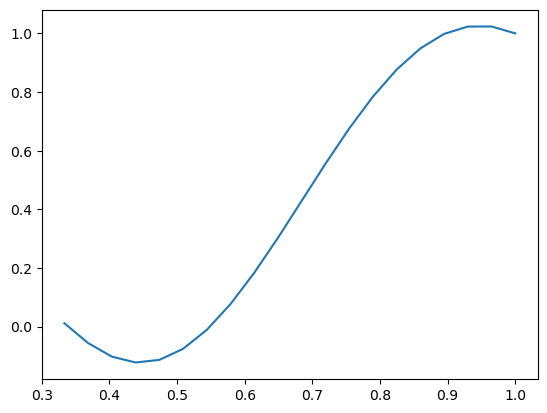

In [19]:
import random

def determinant_of_arbitrary_submatrix(matrix, row_indices, col_indices):
    """
    Calculate the determinant of an arbitrary principal submatrix of a given matrix.

    :param matrix: The input matrix as a 2D NumPy array.
    :param row_indices: List of row indices to include in the submatrix.
    :param col_indices: List of column indices to include in the submatrix.
    :return: The determinant of the specified principal submatrix.
    """
    submatrix = matrix[np.ix_(row_indices, col_indices)]  # Extract the specified submatrix
    det = np.linalg.det(submatrix)  # Calculate the determinant

    return det

def generate_random_subset(n, k):
    """
    Generate a random subset of k distinct numbers from 1 to n.

    :param n: The maximum number (inclusive) to choose from.
    :param k: The size of the random subset.
    :return: A list containing k distinct random numbers.
    """
    if k > n:
        raise ValueError("Subset size k cannot be greater than n.")
    # sort from small to large
    subset = sorted(random.sample(range(1, n + 1), k))
    return subset


indices = generate_random_subset(len(calls_adjacency_matrix)-1, 30)
# print(indices)
# print(determinant_of_arbitrary_submatrix(A, indices, indices))

k1 = np.linspace(1/3, 1, 20)
k2 = 1 - k1
determinants = []
for i in range(len(k1)):
    A = k1[i] * (sms_adjacency_matrix + calls_adjacency_matrix) + k2[i] * fb_adjacency_matrix
    A = A + np.identity(len(A))
    determinants.append(determinant_of_arbitrary_submatrix(A, indices, indices))

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Plot the determinant values with respect to k1
ax.plot(k1, determinants)

# ax.set_xlabel('k1')
# ax.set_ylabel('Determinant')
# plt.savefig('determinant_30.png')
plt.show()


### For all layers -- Fixing in-person layer with a unique NE

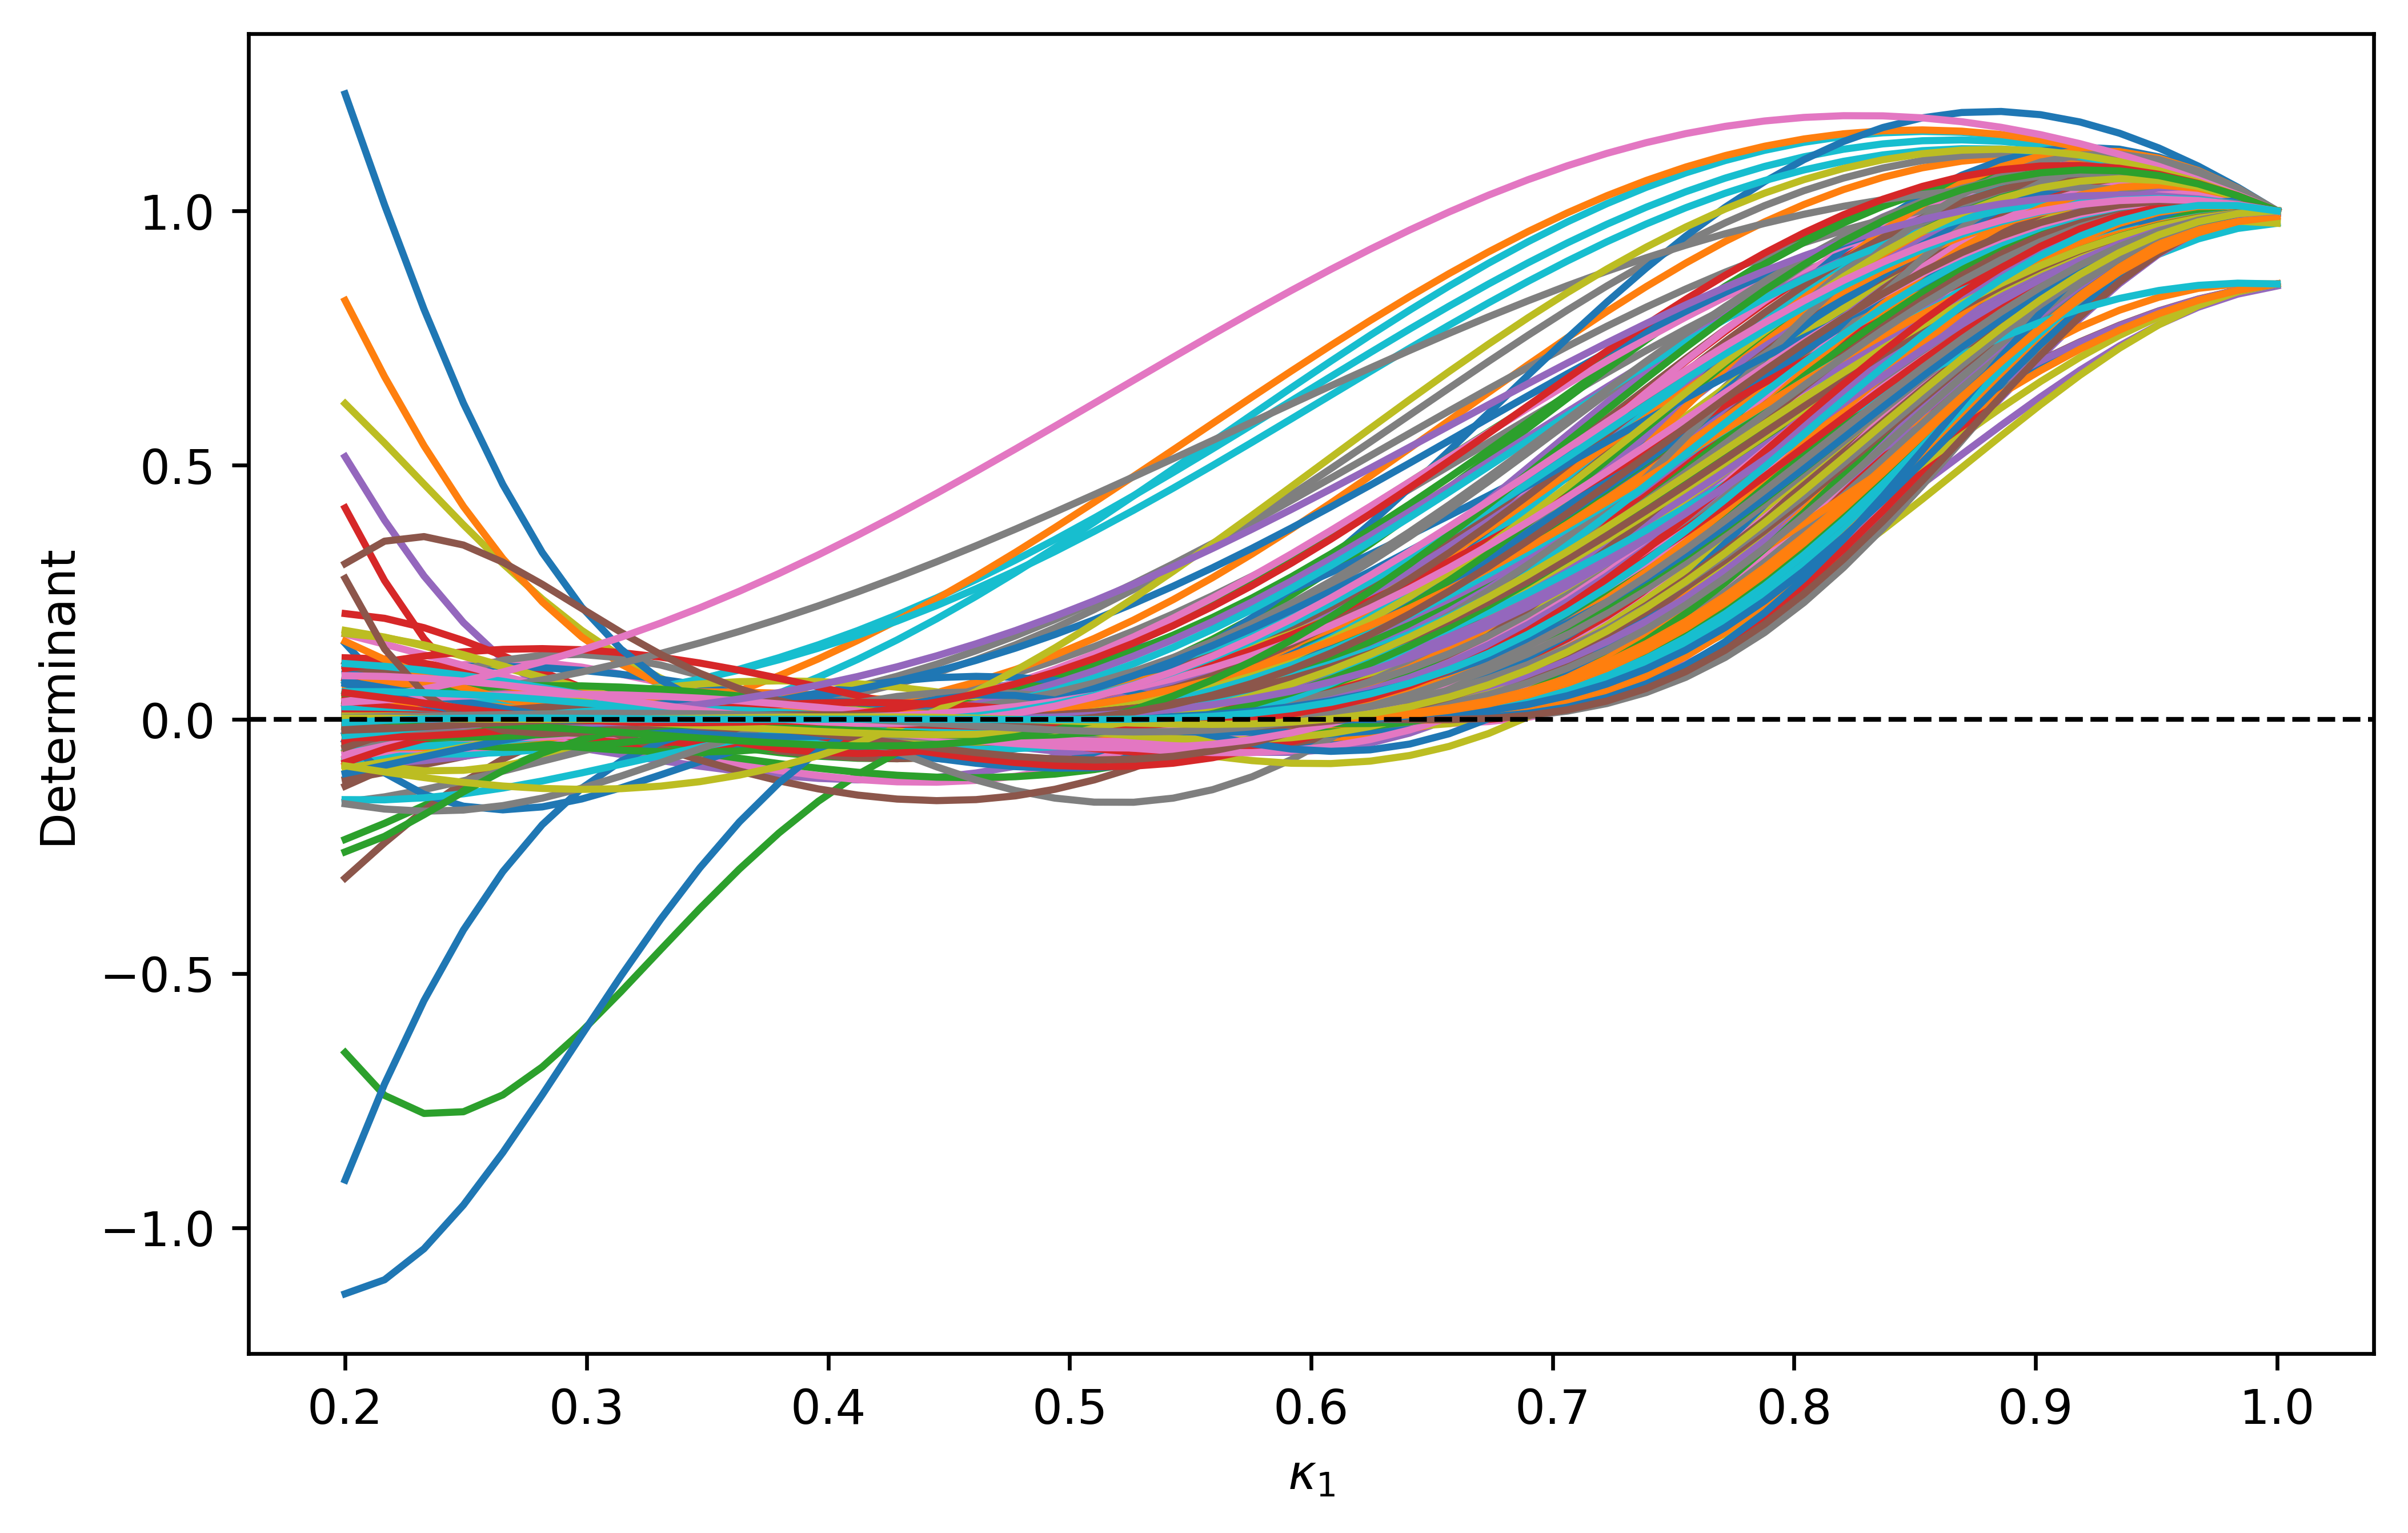

In [26]:
# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
# Placing the plots in the plane 
# ax1 = plt.subplot2grid((3, 3), (0, 0)) 
# ax2 = plt.subplot2grid((3, 3), (0, 2)) 
# ax3 = plt.subplot2grid((3, 3), (1, 1)) 
plt.figure(figsize=(8, 5), dpi=600)


n_nodes = 30
k1_list = []
determinant_list = []
iterations = 500
# for i in range(iterations):
#     indices = generate_random_subset(len(calls_adjacency_matrix)-1, n_nodes)

#     k1 = np.linspace(1/5, 1, 50)
#     k2 = 1 - k1
#     determinants = []
#     for i in range(len(k1)):
#         A = k1[i] * (3/4 * sms_adjacency_matrix + 1/4 * calls_adjacency_matrix) + k2[i] * fb_adjacency_matrix
#         A = A + np.identity(len(A))
#         # plt.axvline(1-k2, color='k', linestyle='dashed', linewidth=1)
#         determinants.append(determinant_of_arbitrary_submatrix(A, indices, indices))
#     determinant_list.append(determinants)
#     k1_list.append(k1)

# for i in range(iterations):
#     ax1.plot(k1_list[i], determinant_list[i])
# ax1.title.set_text('Stronger SMS network')
# ax1.set(xlabel='$\kappa_1$', ylabel='Determinant')


k1_list = []
determinant_list = []
for i in range(iterations):
    indices = generate_random_subset(len(calls_adjacency_matrix)-1, n_nodes)

    k1 = np.linspace(1/5, 1, 50)
    k2 = 1 - k1
    determinants = []
    for i in range(len(k1)):
        A = k1[i] * (1/4 * sms_adjacency_matrix + 3/4 * calls_adjacency_matrix) + k2[i] * fb_adjacency_matrix
        A = A + np.identity(len(A))
        # plt.axvline(1-k2, color='k', linestyle='dashed', linewidth=1)
        determinants.append(determinant_of_arbitrary_submatrix(A, indices, indices))
    determinant_list.append(determinants)
    k1_list.append(k1)

for i in range(iterations):
    plt.plot(k1_list[i], determinant_list[i])
# plt.title('Stronger Calls network')
plt.axhline(0, color='k', linestyle='dashed', linewidth=1)
plt.xlabel('$\kappa_1$')
plt.ylabel('Determinant')




# k1_list = []
# determinant_list = []
# for i in range(iterations):
#     indices = generate_random_subset(len(calls_adjacency_matrix)-1, n_nodes)

#     k1 = np.linspace(1/5, 1, 50)
#     k2 = 1 - k1
#     determinants = []
#     for i in range(len(k1)):
#         A = k1[i] * (2/4 * sms_adjacency_matrix + 2/4 * calls_adjacency_matrix) + k2[i] * fb_adjacency_matrix
#         A = A + np.identity(len(A))
#         # plt.axvline(1-k2, color='k', linestyle='dashed', linewidth=1)
#         determinants.append(determinant_of_arbitrary_submatrix(A, indices, indices))
#     determinant_list.append(determinants)
#     k1_list.append(k1)

# for i in range(iterations):
#     ax3.plot(k1_list[i], determinant_list[i])
# ax3.title.set_text('Similar Calls and SMS networks')
# ax3.set(xlabel='$\kappa_1$')
# ax1.label_outer()
# ax2.label_outer()
# ax3.label_outer()

plt.savefig('determinant_30.png', dpi=60)
plt.show()

In [21]:
k1 = 1
k2 = 1 - k1
iterations = 5000

In [22]:
nodes = [10, 130, 280]
determinants_list = []
for n in nodes:
    determinants = []
    for i in range(iterations):
        indices = generate_random_subset(len(calls_adjacency_matrix)-1, n)
        A = k1 * (1/4 * sms_adjacency_matrix + 3/4*calls_adjacency_matrix) + k2 * fb_adjacency_matrix
        A = A + np.identity(len(A))
        determinants.append(determinant_of_arbitrary_submatrix(A, indices, indices))
    determinants_list.append(determinants)

In [23]:
# print the determinant of the whole matrix
A = k1 * (2/4*sms_adjacency_matrix + 2/4*calls_adjacency_matrix) + k2 * fb_adjacency_matrix
A = A + np.identity(len(A))
print(np.linalg.det(A))

0.528003048282402


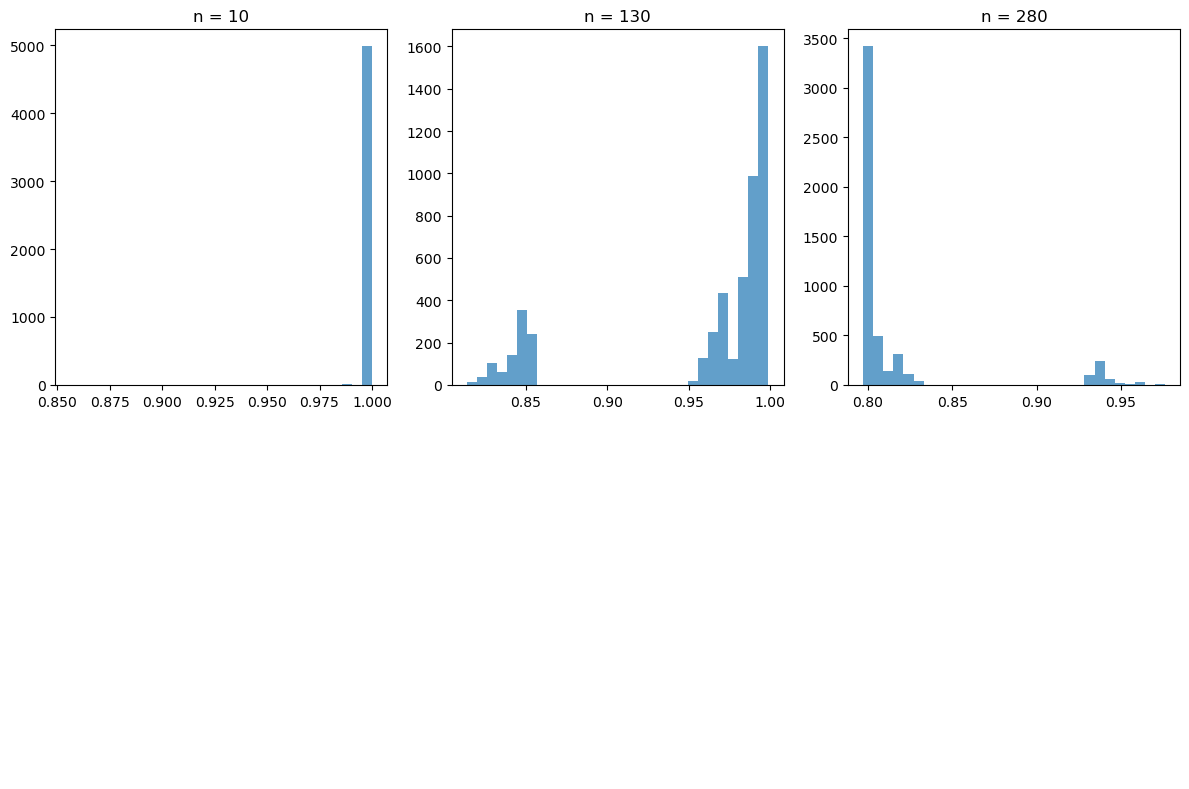

In [24]:
# Plotting histograms in 3x2 subplots
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

for i, ax in enumerate(axs.flatten()):
    if i < len(determinants_list):
        ax.hist(determinants_list[i], bins=30, alpha=0.7)
        ax.set_title(f'n = {nodes[i]}')
    else:
        ax.axis('off')

plt.tight_layout()
plt.savefig('histogram_1.png')
plt.show()

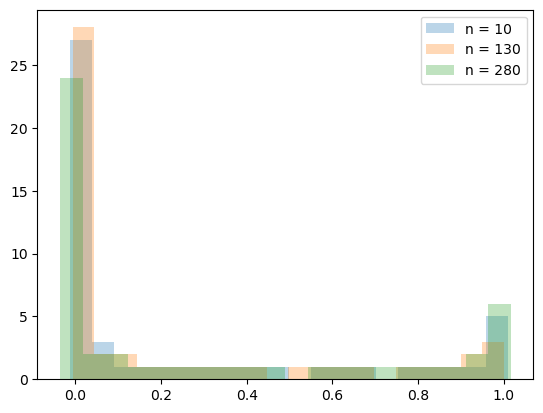

In [25]:
kwargs = dict(histtype='stepfilled', alpha=0.3, bins=20)

for i in range(len(nodes)):
    plt.hist(determinant_list[i], **kwargs)

plt.legend(['n = 10', 'n = 130', 'n = 280'])
plt.savefig('histogram_1.png')
plt.show()